In [1]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
from lungmask import mask as lungmask_fun
from skimage.measure import label, regionprops
from skimage.morphology import dilation,ball,erosion,remove_small_objects


from monai.utils import first, set_determinism
from monai.transforms import (
    RandFlipd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    FillHoles,
    RemoveSmallObjects,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    RandSpatialCropd,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    Invertd,
    DivisiblePadd,
    MapTransform,
    RandWeightedCropd,
    ToTensord,
    Transpose,
    ScaleIntensity,
)
from monai.networks.nets import UNet,VNet,SwinUNETR,UNETR,DynUNet
from monai.metrics import DiceMetric,SurfaceDiceMetric,SurfaceDistanceMetric,HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

if True:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print('plot in line')

device: cuda
plot in line


In [3]:
# class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        print(f"keys to transpose: {self.keys}")

    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0, 2, 3, 1))
                data = rotate(data, 270, axes=(1, 2), reshape=False)
                data = np.flip(data, 1)
                data[data == 2] = int(1)
                data[data != 1] = int(0)
            dictionary[key] = data

        return dictionary


In [5]:
def get_kernels_strides(patch_size, spacing):
    sizes, spacings = patch_size, spacing
    input_size = sizes
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [
            2 if ratio <= 2 and size >= 8 else 1
            for (ratio, size) in zip(spacing_ratio, sizes)
        ]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {input_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides

In [6]:
def LookSortFiles(root_path, all_patientdir):
    CT_fpaths = []
    lbl_fpaths = []
    lung_fpaths = []

    for patient_path in all_patientdir:
        ct_miss = True
        gtv_miss = True
        lung_miss = True
        for root, dirs, files in os.walk(root_path + patient_path, topdown=False):
            for f in files:
                if True:  # 4D Data local
                    if "ct.nii.gz" in f.lower() and not("ave" in f.lower()):
                        CT_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss = False
                    if "_gtv" in f.lower():
                        lbl_fpaths.append(os.path.join(root_path, patient_path, f))
                        gtv_miss = False
                    if "lungmask.nii.gz" in f.lower() and not("ave" in f.lower()):
                        lung_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss = False
            if gtv_miss:
                for f in files:
                    if "_igtv" in f.lower():
                        lbl_fpaths.append(os.path.join(root_path, patient_path, f))
                        gtv_miss = False
            if ct_miss and lung_miss:
                for f in files:
                    if "ex_ct.nii.gz" in f.lower() and ct_miss:
                        CT_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss = False
                    if 'ex_lungmask.nii.gz' in f.lower() and lung_miss:
                        lung_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss = False
            if ct_miss and lung_miss:
                for f in files:
                    if "mar_ct.nii.gz" in f.lower() and ct_miss:
                        CT_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss = False
                    if 'mar_lungmask.nii.gz' in f.lower() and lung_miss:
                        lung_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss = False
            if ct_miss and lung_miss:
                for f in files:
                    if "ct.nii.gz" in f.lower() and ct_miss:
                        CT_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss = False
                    if 'lungmask.nii.gz' in f.lower() and lung_miss:
                        lung_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss = False
            if gtv_miss and len(files) > 0:
                CT_fpaths.pop()
                ct_miss = True
                lung_fpaths.pop()
                lung_miss = True

    print('ct: ', len(CT_fpaths), 'label: ', len(lbl_fpaths), 'lung: ', len(lung_fpaths))
    if False:
        CreateLungMasks(root_path, CT_fpaths)
        print('Rerun the program')
        exit(1)

    CT_fpaths.sort()
    lbl_fpaths.sort()
    lung_fpaths.sort()

    print(CT_fpaths[-1])
    print(lbl_fpaths[-1])
    print(lung_fpaths[-1])


    if (len(CT_fpaths) != len(lbl_fpaths)) or (len(lbl_fpaths) != len(lung_fpaths)):
        print('Different number of files for each structure')
        exit(1)

    return CT_fpaths, lbl_fpaths, lung_fpaths

In [7]:
##if name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
num_workers = 0

# root_path = '/data/p308104/Nifti_Imgs_V0/' #UMCG data on peregrine
#root_path = '/data/p308104/MultipleBP/'
#root_path = '/home/umcg/OneDrive/MultipleBreathingP/'
root_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti/'

#preweight_path = '/data/p308104/weights/v9/'
preweight_path = '/home/umcg/Desktop/AutomaticITV_code/weights/v10/'

figures_path = '/home/umcg/Desktop/AutomaticITV_code/figures_folder_i/'

cache = False
lf_select = None # NOT Needed for testing

SelectModel = 1  # 0 Swin  - 1 Dyn
figures_folder_i = figures_path+'figures_DynU_v10'
pretrained_path = preweight_path + 'best_DynUnet_V10_UMCG_Loss3.pth'
name_run = "TestRun" + str(SelectModel) + "LF" + str(lf_select) + "run1"
print(name_run)


device: cuda
TestRun1LFNonerun1


In [8]:
##MAIN
all_patientdir = []
all_patientdir = os.listdir(root_path)
all_patientdir.sort()
print(len(all_patientdir),'in',name_run)

CT_fpaths, lbl_fpaths, lung_fpaths = LookSortFiles(root_path, all_patientdir)

#Create data dictionat
data_dicts = [
    {"image": image_name,"lung":lung_name,"label": label_name}
    for image_name,lung_name,label_name in zip(CT_fpaths,lung_fpaths,lbl_fpaths)
]
train_files, val_files = data_dicts[:], data_dicts[:]
print('train val len:',len(train_files),'-',len(val_files))

# HU are -1000 air , 0 water , usually normal tissue are around 0, top values should be around 100, bones are around 1000
minmin_CT = -1024
maxmax_CT = 200 

#Create Compose functions for preprocessing of train and validation
set_determinism(seed=0)
image_keys = ["image","lung","label"]
p = .5 #Data aug transform probability
size = 96
image_size = (size,size,size)
pin_memory = True if num_workers > 0 else False  # Do not change

val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        ToTensord(keys=image_keys),
    ]
)

# Check the images after the preprocessing
if cache:  # Cache
    #train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
    #train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=num_workers)
    val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0,
                          num_workers=int(num_workers // 2))
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=int(num_workers // 2), pin_memory=pin_memory)
else:
    #train_ds = Dataset(data=train_files, transform=train_transforms)
    #train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
    val_ds = Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)  # ,collate_fn=pad_list_data_collate)


63 in TestRun1LFNonerun1
ct:  63 label:  63 lung:  63
/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti/9490514/9490514_4D thorax 2.0  2.0  Br38  3  50% iMAR_ct.nii.gz
/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti/9490514/9490514_rtstruct_GTV.nii.gz
/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti/9490514/9490514_4D thorax 2.0  2.0  Br38  3  50% iMAR_LungMask.nii.gz
train val len: 63 - 63
keys to transpose: ('image', 'lung', 'label')


px info:1,image shape: (288, 288, 192),lung shape: (288, 288, 192), label shape: (288, 288, 192)


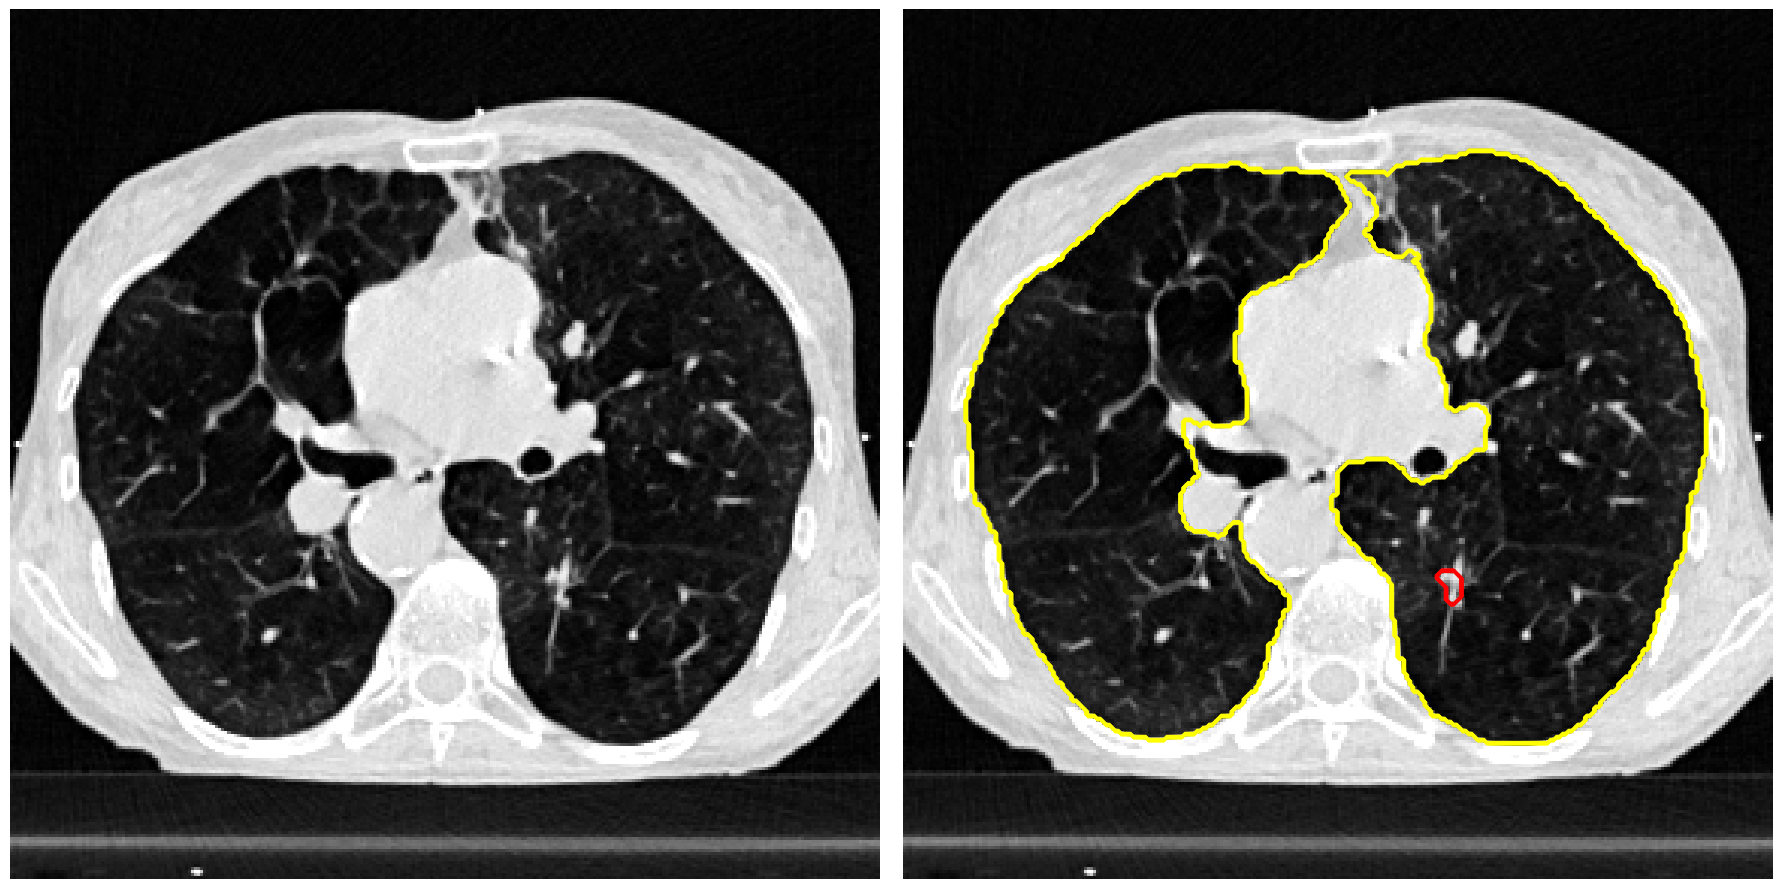

px info:2,image shape: (288, 192, 192),lung shape: (288, 192, 192), label shape: (288, 192, 192)


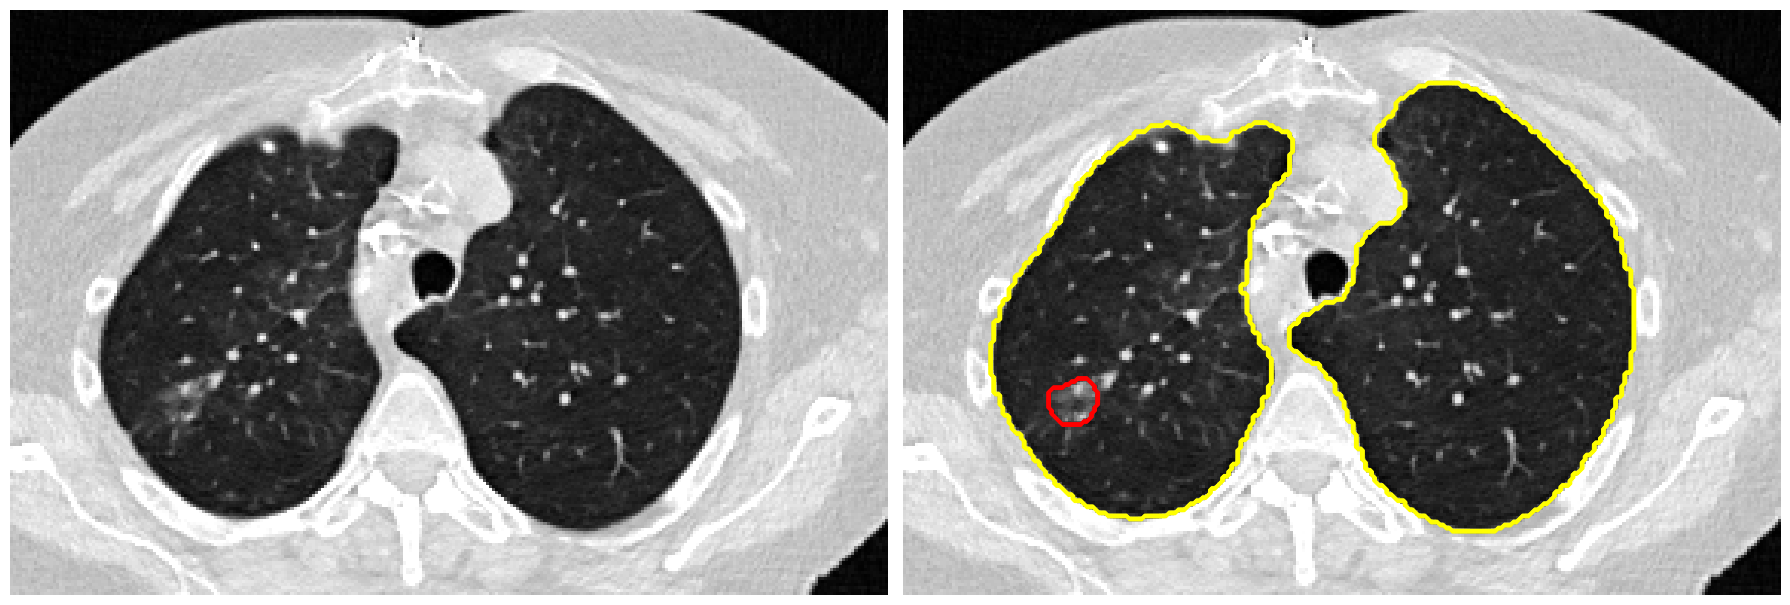

px info:3,image shape: (288, 288, 192),lung shape: (288, 288, 192), label shape: (288, 288, 192)


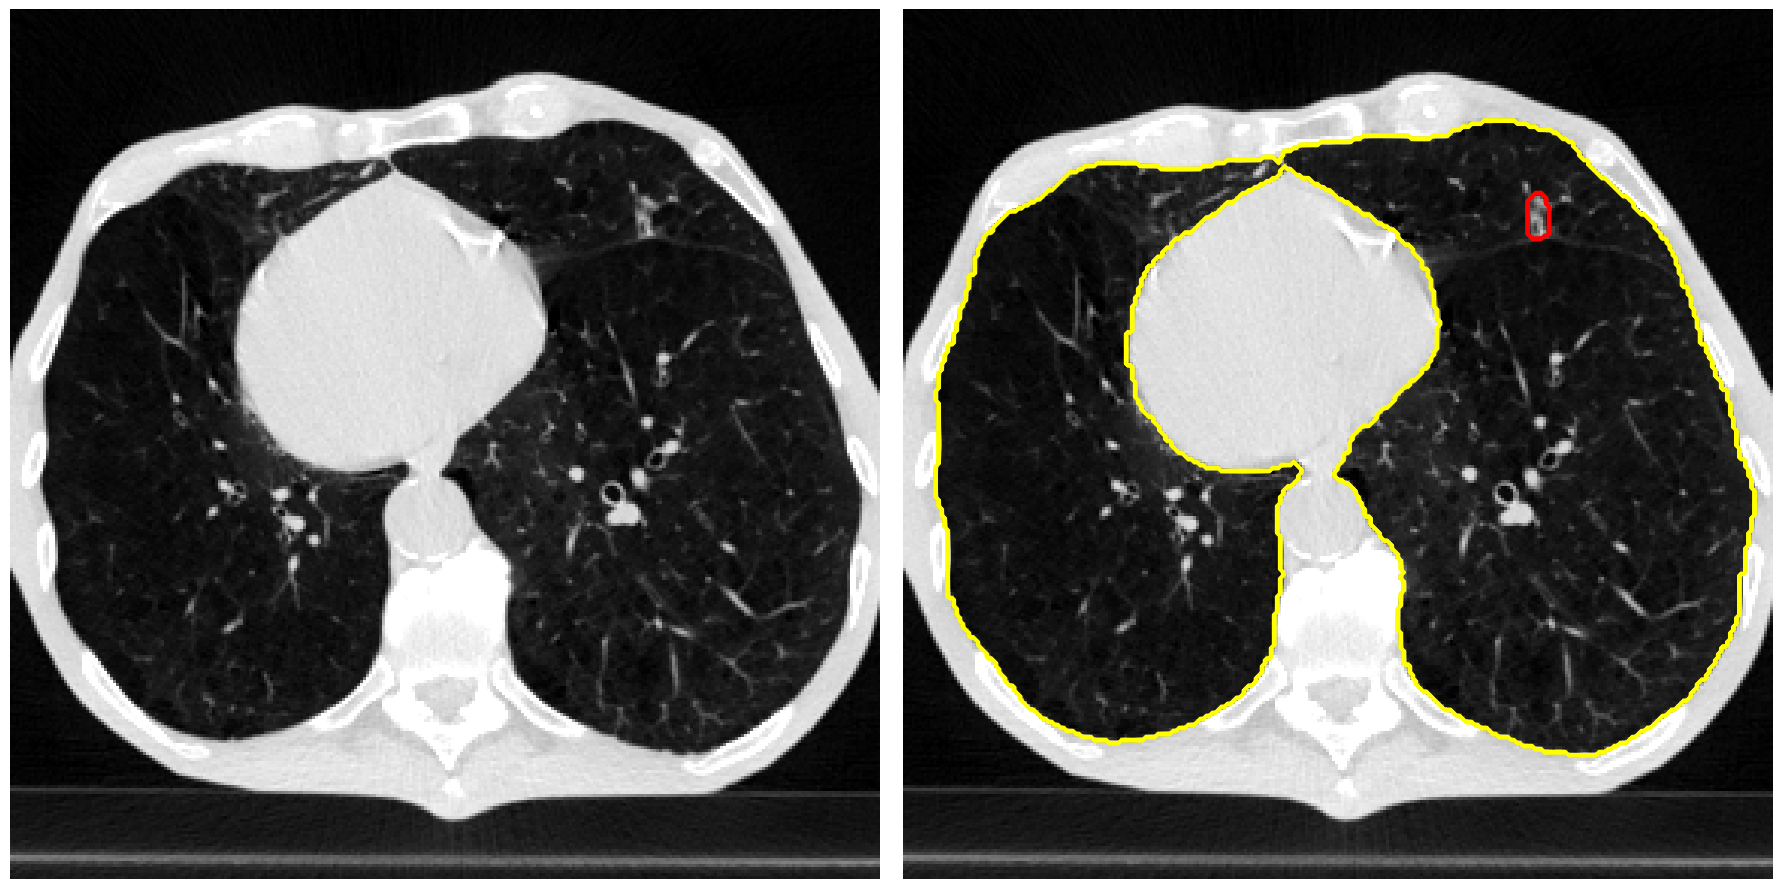

In [8]:
#Check the images after the preprocessing
figsize = (18, 9)
check_ds =Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)
if True:
    count = 1
    for batch_data in check_loader:
        #batch_data = first(check_loader)
        image,lung, label = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["label"][0][0])
        print(f"px info:{count },image shape: {image.shape},lung shape: {lung.shape}, label shape: {label.shape}")
        count+=1
        for i in range(label.shape[2]):
            if torch.sum(label[:,:,i])>0:
                fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
                plt.subplot(1,2,1),plt.imshow(np.rot90(image[:,:,i]),cmap='gray'),plt.axis('off')
                plt.subplot(1,2,2),plt.imshow(np.rot90(image[:,:,i]),cmap='gray'),plt.axis('off')
                plt.contour(np.rot90(lung[:, :,i]),colors='yellow')
                plt.contour(np.rot90(label[:,:,i]),colors='red')
                plt.tight_layout(),plt.show()
                break
        if count>3:
            break


MAIN

In [9]:
# Create the model
spatial_dims = 3
max_epochs = 250
in_channels = 1
out_channels = 2  # including background
lr = 1e-3  # 1e-4
weight_decay = 1e-5
T_0 = 40  # Cosine scheduler

task_id = "06"
deep_supr_num = 1  # when is 3 shape of outputs/labels dont match
patch_size = image_size
spacing = [1, 1, 1]
kernels, strides = get_kernels_strides(patch_size, spacing)
if SelectModel:
    print("MODEL Dyn")
    task_id = "06"
    model = DynUNet(
        spatial_dims=3,
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        norm_name="instance",
        deep_supervision=False,  # when is 3 shape of outputs/labels dont match
        deep_supr_num=deep_supr_num,
    ).to(device)
else:
    print("MODEL SWIN")
    model = SwinUNETR(
        image_size,
        in_channels, out_channels,
        use_checkpoint=True,
        feature_size=48,
        #spatial_dims=spatial_dims
    ).to(device)

#metrics, no definition of :
#NO Loss Function
#NO Optimizer
# Load pretrained model
if pretrained_path is not(None):
    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device(device)))
    print('Using pretrained weights!')


MODEL Dyn
Using pretrained weights!


63
Px:  0070683
num de blobs in label:  1
label bbox  (163, 86, 102, 190, 110, 116) size 3613
num de blobs predicted:  1
prediction bbox (165, 89, 102, 190, 110, 116) size 2458
True Positive:  True
Scores post    : 0.741150438785553
Haus post 1 class: 4.123105625617661
TP:  2450 FN:  1163.0 FP:  8.0
Px:  0442524
num de blobs in label:  1
label bbox  (42, 46, 132, 73, 78, 147) size 5864
num de blobs predicted:  1
prediction bbox (44, 48, 132, 70, 77, 147) size 4868
True Positive:  True


KeyboardInterrupt: 

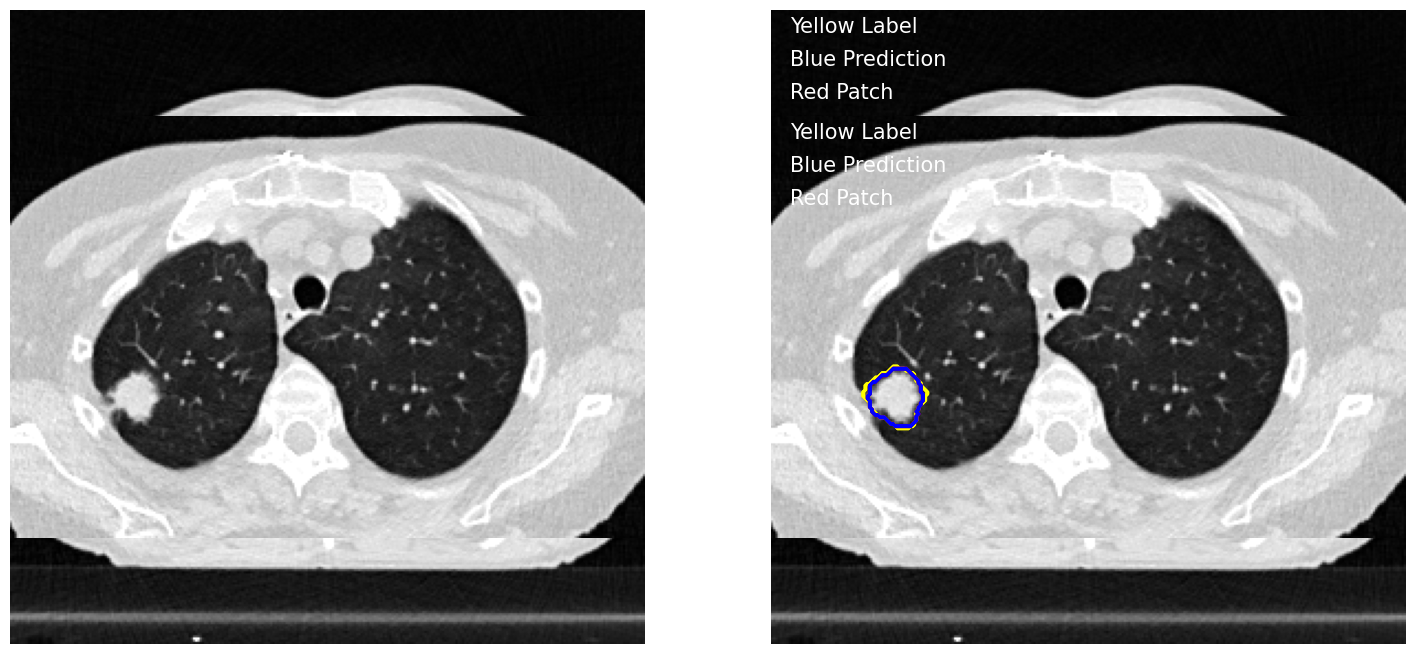

In [15]:
##TESTING
#Define PostTranforms
out_channels = 2  # including background
post_transforms = Compose(
    [
        EnsureType(),
        AsDiscrete(argmax=True, threshold=0.5),
        #FillHoles(applied_labels=1, connectivity=0),
        #RemoveSmallObjects(min_size=64, connectivity=3, independent_channels=True),
        ScaleIntensity(minv=0.0, maxv=1.0),
        KeepLargestConnectedComponent(applied_labels=None,is_onehot=False,connectivity=2,num_components=1),
    ]
)
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, threshold=0.1),
                     ScaleIntensity(minv=0.0, maxv=1.0)])
post_label = Compose([EnsureType(), AsDiscrete(threshold=0.5)], )

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95)

# Testing the model
sumTP=0
sumFN=0
sumFP=0

sum_voxTP=0
sum_voxFN=0
sum_voxFP=0

ListTP=[]
ListFN=[]
ListFP=[]

metrics=True
full_volume_disp = True

count = 0
nr_images = 8
rows=3
figsize = (18, 9)
all_metrics = []
figs = False #Show and save Figures
print(len(val_loader))
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        voxTP=0
        voxFN=0
        voxFP=0
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),)
        roi_size = image_size
        sw_batch_size = 1
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        
        px = val_data["image"].to('cpu').meta["filename_or_obj"][0].split('/')[-2]
        print('Px: ',px)
        
        #newGTV_name = val_data["image"].meta["filename_or_obj"][0][:-9] + 'aGTV.nii.gz'
        #bp = 'NoBpSpec'#val_data["image"].meta["filename_or_obj"][0].split('%')[-2][-2:]
        #print('new GTV name:',newGTV_name)

        val_outPost = [post_transforms(i) for i in decollate_batch(val_outputs)]
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
            
        image = val_inputs[0].detach().cpu().numpy()
        image = image.squeeze()
        
        lbl_3dnp = val_labels[0].detach().cpu().numpy()
        lbl_3dnp = lbl_3dnp.squeeze()
        lbl_3dnp = dilation(lbl_3dnp, ball(2))
        
        label_img = label(lbl_3dnp)
        regions = regionprops(label_img)
        
        print("num de blobs in label: ",len(label_regions))
        for i in range(len(regions)):
            r = regions[i]
            attrs = [a for a in r.__dir__() if not a.startswith('_')]
            print('label bbox ',r.bbox,"size",len(r.coords))
            lbl_bbox = r.bbox
                
        out_3dnp = val_outPost[0].detach().cpu().numpy()
        out_3dnp = out_3dnp[0].squeeze()
        out_3dnp = dilation(out_3dnp, ball(2))
        
        
        label_out_3dnp = label(out_3dnp)
        props = regionprops(label_out_3dnp)

        print("num de blobs predicted: ",len(props))
        for i in range(len(props)):
            r = props[i]
            attrs = [a for a in r.__dir__() if not a.startswith('_')]
            print('prediction bbox',r.bbox,"size",len(r.coords))
            
            patch = np.zeros(out_3dnp.shape)
            for i in range(len(r.coords)): 
                patch[r.coords[i][0],r.coords[i][1],r.coords[i][2]]=1

            TP = False
            for j in range(len(r.coords)):
                if (r.coords[j][0]>lbl_bbox[0] and r.coords[j][0]<lbl_bbox[3]) and(r.coords[j][1]>lbl_bbox[1] and r.coords[j][1]<lbl_bbox[4]) and (r.coords[j][2]>lbl_bbox[2] and r.coords[j][2]<lbl_bbox[5]):
                    TP=True
                    voxTP+=1
            sumPredicted =np.sum(out_3dnp)
            sumGroundT=np.sum(lbl_3dnp)
            voxFP=sumPredicted-voxTP
            voxFN=sumGroundT-voxTP
            
                    
            print('True Positive: ',TP)
            #Plot all images
            if full_volume_disp:
                count=0
                for i in range(lbl_3dnp.shape[2]):
                    if (np.sum(lbl_3dnp[:, :,i],)>0) or (np.sum(patch[:, :,i],)>0):
                        fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
                        ax = fig.add_subplot(121)
                        ax.imshow(np.rot90(image[:, :, i]),cmap='gray'),plt.axis('off')
                        ax = fig.add_subplot(122)
                        ax.imshow(np.rot90(image[:, :, i]),cmap='gray'),plt.axis('off')
                        ax.contour(np.rot90(lbl_3dnp[:,:,i]),colors='yellow')
                        ax.contour(np.rot90(patch[:, :,i]),colors='red')
                        ax.contour(np.rot90(out_3dnp[:, :,i]),colors='blue')
                        ax.text(8, 10, 'Yellow Label', style='normal',color='white',fontsize=15)
                        ax.text(8, 25, 'Blue Prediction', style='normal',color='white',fontsize=15)
                        ax.text(8, 40, 'Red Patch', style='normal',color='white',fontsize=15)
                        #plt.show()

                        if not os.path.exists(os.path.join(figures_folder_i, px)):
                            os.makedirs(os.path.join(figures_folder_i, px))

                        plt.savefig(os.path.join(figures_folder_i, px, 'FullV_final_V10{}.png'.format(i)))

            # compute metric for current iteration
            if metrics:
                #DICE
                dice_metric(y_pred=val_outPost, y=val_labels) #[0][1:2, :, :, :] [0]
                dice1 = dice_metric.aggregate().item()
                print('Scores post    :', dice1)
                dice_metric.reset()

                hausdorff_metric(y_pred=val_outPost, y=val_labels)
                hausd1 = hausdorff_metric.aggregate().item()
                hausdorff_metric.reset()
                print('Haus post 1 class:', hausd1)
                
                #sdice1 = surfDiceFun_1Class(val_labels, val_outPost)
                #print('SurfFice post 1 class:', sdice1)

            if TP:
                sumTP = sumTP+1
                ListTP.append(px)
            if not(TP):
                sumFN = sumFN+1
                ListFN.append(px)
            if len(props)>1:
                sumFP = sumFP+1
                ListFP.append(px)
                
            print('TP: ',voxTP,'FN: ',voxFN,'FP: ',voxFP)
            break
            sum_voxTP+=voxTP
            sum_voxFN+=voxFN
            sum_voxFP+=voxFP

        
print("Sensitivity: ",sumTP/(sumTP+sumFN))
print("Precision: ",sumTP/(sumTP+sumFP))

print(sumTP,sumFN,sumFP)

In [12]:
lbl_3dnp = val_labels[0].detach().cpu().numpy()
lbl_3dnp = lbl_3dnp.squeeze()
lbl_3dnp = dilation(lbl_3dnp, ball(2))
label_img = label(lbl_3dnp)
label_regions = regionprops(label_img)

print("num de blobs in label: ",len(label_regions))
for i in range(len(regions)):
    r = regions[i]
    attrs = [a for a in r.__dir__() if not a.startswith('_')]
    print('label bbox ',r.bbox,"size",len(r.coords))
    lbl_bbox = r.bbox

num de blobs in label:  1
label bbox  (163, 86, 102, 190, 110, 116) size 3613


In [13]:
label_img.shape

(288, 288, 192)